Initial level:
#####
#@$.#
#####

Running UCS (reference optimal push-cost)...
  UCS: {'found': True, 'cost': 1, 'time': 8.225440979003906e-05, 'nodes': 2, 'max_frontier': 1, 'visited': 2, 'actions': ['Push (1, 2) Right']}
Running BFS ...
  -> BFS result: found=True, cost=1, time=0.000s, nodes=2, max_front=1, visited≈2
Running UCS ...
  -> UCS result: found=True, cost=1, time=0.000s, nodes=2, max_front=1, visited≈2
Running Greedy ...
  -> Greedy result: found=True, cost=1, time=0.000s, nodes=2, max_front=1, visited≈2
Running A* ...
  -> A* result: found=True, cost=1, time=0.000s, nodes=2, max_front=1, visited≈2


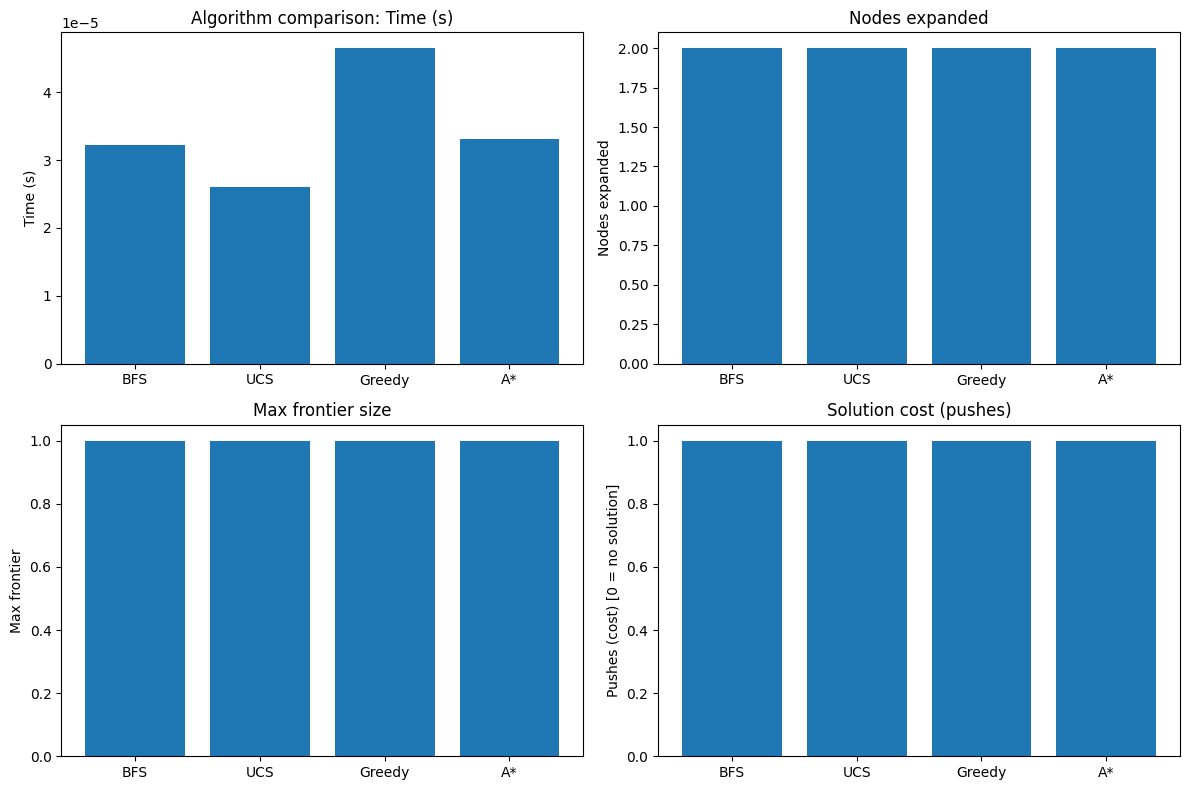


=== Summary ===
Alg      Found  Cost   Optimal? Time(s)    Nodes     
BFS      True   1      YES      0.000      2         
UCS      True   1      YES      0.000      2         
Greedy   True   1      YES      0.000      2         
A*       True   1      YES      0.000      2         


In [2]:
#!/usr/bin/env python3
"""
Sokoban push-only solver + simple deadlock checks + algorithm comparison plots.

- State representation: (player_pos, frozenset(box_positions))
- Push-only expansion:
    * compute reachable tiles for player given boxes (BFS)
    * enumerate legal pushes: player stands at "behind" cell and pushes box into "ahead" cell
- Deadlock detection (simple):
    * box in a corner (two orthogonal adjacent walls) and not a goal -> deadlock
    * 2x2 block of boxes (none on goals) -> deadlock
- Heuristic: sum of Manhattan distances with exact assignment (permutations) for <=7 boxes
- Algorithms: BFS, UCS (push-cost), Greedy best-first, A*
- Plots: 4 bar charts (time, nodes, max_frontier, cost)
"""

from collections import deque, namedtuple
import heapq, time
from itertools import permutations
import matplotlib.pyplot as plt
import math

Node = namedtuple("Node", ["state", "parent", "action", "cost", "depth"])

# ---------------------------
# Parser / grid utils
# ---------------------------
def parse_level(lines):
    """Parse ASCII level into grid, player, boxes, goals."""
    grid = [list(line.rstrip("\n")) for line in lines]
    rows = len(grid)
    cols = max(len(row) for row in grid)
    for row in grid:
        if len(row) < cols:
            row.extend(' ' * (cols - len(row)))
    player = None
    boxes = set()
    goals = set()
    for r in range(rows):
        for c in range(cols):
            ch = grid[r][c]
            if ch == '@':
                player = (r, c); grid[r][c] = ' '
            elif ch == '+':
                player = (r, c); goals.add((r, c)); grid[r][c] = '.'
            elif ch == '$':
                boxes.add((r, c)); grid[r][c] = ' '
            elif ch == '*':
                boxes.add((r, c)); goals.add((r, c)); grid[r][c] = '.'
            elif ch == '.':
                goals.add((r, c))
            # '#' stays wall, ' ' floor.
    return grid, player, frozenset(boxes), frozenset(goals)

def print_grid(grid, player, boxes, goals):
    rows = len(grid); cols = len(grid[0])
    out = []
    for r in range(rows):
        line = []
        for c in range(cols):
            pos = (r, c)
            if pos == player:
                line.append('+' if pos in goals else '@')
            elif pos in boxes:
                line.append('*' if pos in goals else '$')
            else:
                if pos in goals:
                    line.append('.')
                else:
                    ch = grid[r][c]
                    line.append('#' if ch == '#' else ' ')
        out.append(''.join(line))
    print("\n".join(out))
    print()

# ---------------------------
# Mechanics (push-only)
# ---------------------------
DIRS = {'Up':(-1,0), 'Down':(1,0), 'Left':(0,-1), 'Right':(0,1)}

def in_bounds(grid, pos):
    r,c = pos
    return 0 <= r < len(grid) and 0 <= c < len(grid[0])

def is_free_cell(grid, pos, boxes):
    """Cell is floor (not wall) and not occupied by a box."""
    if not in_bounds(grid, pos):
        return False
    if grid[pos[0]][pos[1]] == '#':
        return False
    if pos in boxes:
        return False
    return True

def reachable_tiles(grid, player, boxes):
    """
    BFS for player reachable positions given current box configuration.
    Boxes act as obstacles.
    """
    q = deque([player])
    seen = {player}
    while q:
        p = q.popleft()
        for d in DIRS.values():
            np = (p[0]+d[0], p[1]+d[1])
            if np in seen: continue
            if not in_bounds(grid, np): continue
            if grid[np[0]][np[1]] == '#': continue
            if np in boxes: continue
            seen.add(np)
            q.append(np)
    return seen

# Deadlock detection helpers
def is_corner_deadlock(pos, grid):
    """Return True if pos is a corner (two orthogonal walls)."""
    r,c = pos
    # check wall up or down and left or right combination
    up = (not in_bounds(grid, (r-1,c))) or grid[r-1][c] == '#'
    down = (not in_bounds(grid, (r+1,c))) or grid[r+1][c] == '#'
    left = (not in_bounds(grid, (r,c-1))) or grid[r][c-1] == '#'
    right = (not in_bounds(grid, (r,c+1))) or grid[r][c+1] == '#'
    # corner if (up or down) and (left or right), with at least one on each axis
    if (up or down) and (left or right):
        # but not strictly if only one neighbor exists due to boundary; treat consistently
        return True
    return False

def forms_2x2_block(boxes, pos):
    """Check if pos is part of a 2x2 block of boxes (simple freeze)."""
    r,c = pos
    # four possible 2x2 origins containing pos:
    origins = [(r, c), (r-1, c), (r, c-1), (r-1, c-1)]
    for orr, oc in origins:
        cells = [(orr, oc), (orr+1, oc), (orr, oc+1), (orr+1, oc+1)]
        if all(cell in boxes for cell in cells):
            return True
    return False

def is_deadlock_state(boxes, grid, goals):
    """
    Simple deadlock detection:
    - If any box not on a goal is in a corner (two adjacent walls) -> deadlock
    - If any box is part of a 2x2 block of boxes and none in that block are goals -> deadlock
    This is conservative and not complete, but prunes many impossible states.
    """
    bset = set(boxes)
    for b in boxes:
        if b in goals:
            continue
        # corner deadlock
        r,c = b
        up = (not in_bounds(grid, (r-1,c))) or grid[r-1][c] == '#'
        down = (not in_bounds(grid, (r+1,c))) or grid[r+1][c] == '#'
        left = (not in_bounds(grid, (r,c-1))) or grid[r][c-1] == '#'
        right = (not in_bounds(grid, (r,c+1))) or grid[r][c+1] == '#'
        if (up or down) and (left or right):
            # If the adjacent wall combination corresponds to a true corner (both walls present)
            # we must ensure there are actual walls in both orthogonal directions:
            vertical = up and left or up and right or down and left or down and right
            # Simpler: require at least one neighbor on vertical axis and one on horizontal axis be walls
            if ( (up or down) and (left or right) ):
                # treat as deadlock, except if one of those neighbor cells is a goal (rare)
                # But to be slightly more permissive: if any of the orthogonal neighbor cells is a goal, allow.
                orth_neighbors = []
                if up: orth_neighbors.append((r-1,c))
                if down: orth_neighbors.append((r+1,c))
                if left: orth_neighbors.append((r,c-1))
                if right: orth_neighbors.append((r,c+1))
                # if none of the orth neighbors are goals, declare deadlock
                if not any(n in goals for n in orth_neighbors):
                    return True
        # 2x2 block deadlock
        if forms_2x2_block(bset, b):
            # check if any of those 4 cells is a goal; if none, deadlock
            origin_cells = [
                (r, c),
                (r-1, c),
                (r, c-1),
                (r-1, c-1)
            ]
            # Build the actual 4 cells combinations and test each origin combination
            for orr, oc in [(r, c), (r-1, c), (r, c-1), (r-1, c-1)]:
                cells = [(orr, oc), (orr+1, oc), (orr, oc+1), (orr+1, oc+1)]
                if all(cell in bset for cell in cells):
                    if not any(cell in goals for cell in cells):
                        return True
    return False

def push_successors(grid, state, goals):
    """
    Push-only successors:
    - compute player reachable tiles
    - for each box, for each direction, if player can stand behind the box and the cell ahead is free -> push
    - returns list of (action_label, new_state, cost=1)
    """
    player, boxes = state
    boxes_set = set(boxes)
    reachable = reachable_tiles(grid, player, boxes_set)
    succs = []
    for box in boxes:
        br, bc = box
        for dir_name, d in DIRS.items():
            behind = (br - d[0], bc - d[1])  # player must stand here to push
            ahead = (br + d[0], bc + d[1])   # box will move here
            # bounds and obstacles
            if not in_bounds(grid, behind): continue
            if not in_bounds(grid, ahead): continue
            if grid[ahead[0]][ahead[1]] == '#': continue
            if ahead in boxes_set: continue
            if behind not in reachable: continue
            # legal push: produce new state
            new_boxes = set(boxes_set)
            new_boxes.remove(box)
            new_boxes.add(ahead)
            # player ends up at the box's old position after pushing
            new_player = box
            new_state = (new_player, frozenset(new_boxes))
            # deadlock filter
            if is_deadlock_state(new_state[1], grid, goals):
                continue
            action = f"Push {box} {dir_name}"
            succs.append((action, new_state, 1))
    return succs

def is_goal_state(state, goals):
    return set(state[1]) == set(goals)

# ---------------------------
# Heuristic (matching)
# ---------------------------
def manhattan(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def heuristic_sum_min_assignment(boxes, goals):
    """
    Admissible heuristic for push-space: minimal sum of manhattan distances between boxes and goals.
    Exact matching by permutations for small box counts (<=7).
    """
    boxes = list(boxes); goals = list(goals)
    b = len(boxes); g = len(goals)
    if b == 0: return 0
    if b > g: return float('inf')
    if b <= 7:
        best = float('inf')
        for perm in permutations(range(g), b):
            s = 0
            for i, gi in enumerate(perm):
                s += manhattan(boxes[i], goals[gi])
                if s >= best:
                    break
            if s < best:
                best = s
        return best
    else:
        remaining = set(goals)
        total = 0
        for bx in boxes:
            nearest = min(remaining, key=lambda gpos: manhattan(bx, gpos))
            total += manhattan(bx, nearest)
            remaining.remove(nearest)
            if not remaining:
                break
        return total

# ---------------------------
# Reconstruct path
# ---------------------------
def reconstruct_path(node):
    actions = []
    states = []
    while node.parent is not None:
        actions.append(node.action)
        states.append(node.state)
        node = node.parent
    actions.reverse()
    states.reverse()
    return actions, states

# ---------------------------
# Search algorithms (push-space)
# ---------------------------
def bfs_push(grid, start_state, goals, max_nodes=200000):
    t0 = time.time()
    frontier = deque([Node(start_state, None, None, 0, 0)])
    visited = set([start_state])
    nodes_expanded = 0
    max_frontier = 1
    while frontier:
        node = frontier.popleft()
        nodes_expanded += 1
        if is_goal_state(node.state, goals):
            actions, states = reconstruct_path(node)
            return {'found': True, 'cost': node.cost, 'time': time.time() - t0,
                    'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(visited),
                    'actions': actions}
        for action, succ_state, c in push_successors(grid, node.state, goals):
            if succ_state not in visited:
                visited.add(succ_state)
                child = Node(succ_state, node, action, node.cost + c, node.depth + 1)
                frontier.append(child)
        max_frontier = max(max_frontier, len(frontier))
        if nodes_expanded > max_nodes:
            break
    return {'found': False, 'cost': None, 'time': time.time() - t0,
            'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(visited),
            'actions': None}

def ucs_push(grid, start_state, goals, max_nodes=500000):
    t0 = time.time()
    frontier = []
    counter = 0
    heapq.heappush(frontier, (0, counter, Node(start_state, None, None, 0, 0)))
    best_cost = {start_state: 0}
    nodes_expanded = 0
    max_frontier = 1
    while frontier:
        cost, _, node = heapq.heappop(frontier)
        nodes_expanded += 1
        if cost > best_cost.get(node.state, float('inf')):
            continue
        if is_goal_state(node.state, goals):
            actions, states = reconstruct_path(node)
            return {'found': True, 'cost': node.cost, 'time': time.time() - t0,
                    'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(best_cost),
                    'actions': actions}
        for action, succ_state, c in push_successors(grid, node.state, goals):
            new_cost = node.cost + c
            if new_cost < best_cost.get(succ_state, float('inf')):
                best_cost[succ_state] = new_cost
                counter += 1
                child = Node(succ_state, node, action, new_cost, node.depth + 1)
                heapq.heappush(frontier, (new_cost, counter, child))
        max_frontier = max(max_frontier, len(frontier))
        if nodes_expanded > max_nodes:
            break
    return {'found': False, 'cost': None, 'time': time.time() - t0,
            'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(best_cost),
            'actions': None}

def greedy_push(grid, start_state, goals, max_nodes=200000):
    t0 = time.time()
    frontier = []
    counter = 0
    h0 = heuristic_sum_min_assignment(start_state[1], goals)
    heapq.heappush(frontier, (h0, counter, Node(start_state, None, None, 0, 0)))
    visited = set([start_state])
    nodes_expanded = 0
    max_frontier = 1
    while frontier:
        _, _, node = heapq.heappop(frontier)
        nodes_expanded += 1
        if is_goal_state(node.state, goals):
            actions, states = reconstruct_path(node)
            return {'found': True, 'cost': node.cost, 'time': time.time() - t0,
                    'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(visited),
                    'actions': actions}
        for action, succ_state, c in push_successors(grid, node.state, goals):
            if succ_state not in visited:
                visited.add(succ_state)
                h = heuristic_sum_min_assignment(succ_state[1], goals)
                counter += 1
                child = Node(succ_state, node, action, node.cost + c, node.depth + 1)
                heapq.heappush(frontier, (h, counter, child))
        max_frontier = max(max_frontier, len(frontier))
        if nodes_expanded > max_nodes:
            break
    return {'found': False, 'cost': None, 'time': time.time() - t0,
            'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(visited),
            'actions': None}

def astar_push(grid, start_state, goals, max_nodes=200000):
    t0 = time.time()
    frontier = []
    counter = 0
    h0 = heuristic_sum_min_assignment(start_state[1], goals)
    heapq.heappush(frontier, (h0, counter, Node(start_state, None, None, 0, 0)))
    best_cost = {start_state: 0}
    nodes_expanded = 0
    max_frontier = 1
    while frontier:
        f, _, node = heapq.heappop(frontier)
        nodes_expanded += 1
        if is_goal_state(node.state, goals):
            actions, states = reconstruct_path(node)
            return {'found': True, 'cost': node.cost, 'time': time.time() - t0,
                    'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(best_cost),
                    'actions': actions}
        for action, succ_state, c in push_successors(grid, node.state, goals):
            new_cost = node.cost + c
            if new_cost < best_cost.get(succ_state, float('inf')):
                best_cost[succ_state] = new_cost
                h = heuristic_sum_min_assignment(succ_state[1], goals)
                counter += 1
                child = Node(succ_state, node, action, new_cost, node.depth + 1)
                heapq.heappush(frontier, (new_cost + h, counter, child))
        max_frontier = max(max_frontier, len(frontier))
        if nodes_expanded > max_nodes:
            break
    return {'found': False, 'cost': None, 'time': time.time() - t0,
            'nodes': nodes_expanded, 'max_frontier': max_frontier, 'visited': len(best_cost),
            'actions': None}

# ---------------------------
# Runner + plotting
# ---------------------------
def run_all_and_plot(grid, player, boxes, goals):
    start_state = (player, boxes)
    print("Initial level:")
    print_grid(grid, player, boxes, goals)
    # Run algorithms
    algs = [
        ('BFS', bfs_push),
        ('UCS', ucs_push),
        ('Greedy', greedy_push),
        ('A*', astar_push)
    ]
    results = {}
    # Optionally run UCS first to get optimal cost (useful for judging optimality)
    print("Running UCS (reference optimal push-cost)...")
    ucs_res = ucs_push(grid, start_state, goals, max_nodes=500000)
    print("  UCS:", ucs_res)
    optimal_cost = ucs_res['cost'] if ucs_res['found'] else None
    for name, fn in algs:
        print(f"Running {name} ...")
        res = fn(grid, start_state, goals, max_nodes=200000)
        res['optimal_compare_to_ucs'] = (res['cost'] == optimal_cost) if (res['found'] and optimal_cost is not None) else None
        results[name] = res
        print(f"  -> {name} result: found={res['found']}, cost={res['cost']}, time={res['time']:.3f}s, nodes={res['nodes']}, max_front={res['max_frontier']}, visited≈{res['visited']}")
    # Build comparison arrays
    names = list(results.keys())
    times = [results[n]['time'] for n in names]
    nodes = [results[n]['nodes'] for n in names]
    max_front = [results[n]['max_frontier'] for n in names]
    costs = [results[n]['cost'] if results[n]['cost'] is not None else math.nan for n in names]

    # Create 4-subplot bar chart (histogram-like)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    x = range(len(names))

    axs[0,0].bar(x, times)
    axs[0,0].set_xticks(x); axs[0,0].set_xticklabels(names)
    axs[0,0].set_ylabel('Time (s)'); axs[0,0].set_title('Algorithm comparison: Time (s)')

    axs[0,1].bar(x, nodes)
    axs[0,1].set_xticks(x); axs[0,1].set_xticklabels(names)
    axs[0,1].set_ylabel('Nodes expanded'); axs[0,1].set_title('Nodes expanded')

    axs[1,0].bar(x, max_front)
    axs[1,0].set_xticks(x); axs[1,0].set_xticklabels(names)
    axs[1,0].set_ylabel('Max frontier'); axs[1,0].set_title('Max frontier size')

    # Cost: plot only found solutions; display NaN as 0 with hatch to show missing
    cost_vals = [0 if math.isnan(c) else c for c in costs]
    axs[1,1].bar(x, cost_vals)
    axs[1,1].set_xticks(x); axs[1,1].set_xticklabels(names)
    axs[1,1].set_ylabel('Pushes (cost) [0 = no solution]'); axs[1,1].set_title('Solution cost (pushes)')

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n=== Summary ===")
    print("{:<8} {:<6} {:<6} {:<8} {:<10} {:<10}".format("Alg","Found","Cost","Optimal?","Time(s)","Nodes"))
    for n in names:
        r = results[n]
        opt = "n/a" if r['optimal_compare_to_ucs'] is None else ("YES" if r['optimal_compare_to_ucs'] else "NO")
        print("{:<8} {:<6} {:<6} {:<8} {:<10.3f} {:<10}".format(n, str(r['found']), str(r['cost']) if r['cost'] is not None else "-", opt, r['time'], r['nodes']))
    return results

if __name__ == "__main__":
    # A tiny solvable level (one push needed).
    # Legend: # wall, space floor, . goal, $ box, @ player
    example_level = [
        "#####",
        "#@$.#",
        "#####"
    ]
    grid, player, boxes, goals = parse_level(example_level)
    results = run_all_and_plot(grid, player, boxes, goals)
